TODOs:
0. Implement save_model and log 10 sparsity for visualization
1. Run a larger training run -- with full split (5x increase to 256k images) and expansion factor 32. See if this provides good enough results, and see if there's a big dead neurons problem.
  - Anthropic says that hyperparameters matter here (can toy with it a bit)
  - A larger training run can be done just by running 1 epoch on each split and seeing what happens (instead of using the `interleave_datasets` function in [huggingface](https://huggingface.co/docs/datasets/process#concatenate) lol)

2. Implement the resnet and train, try to get some results
3. Implement comparative evals
4. Try replacing nonlinearities (if relu is killing features)
5. linear warmup
6. find out if the imagenet split is reasonably distributed

## Initial CLIP Model Setup

There's some setup stuff we need to take care of first. These packages are installed using pip magic, so we shouldn't need to run this cell again (it lowkey takes a while)

In [ ]:
# 1 · GPU-enabled PyTorch + torchvision, compiled for CUDA 12.6
%pip install --quiet "torch==2.7.*" "torchvision==0.22.*" \
                 --index-url https://download.pytorch.org/whl/cu126

# 2 · CLIP and its tiny helpers
%pip install --quiet ftfy regex tqdm \
                 git+https://github.com/openai/CLIP.git

%pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 822.1/822.1 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 133.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156

In [ ]:
import torch, clip
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

print("torch", torch.__version__, "| CUDA OK? ", torch.cuda.is_available())

#####################################################
#    CHANGE THIS TO DEVICE="CUDA" WHEN TRAINING!    #
#####################################################
device = "cuda"


model_vit, vit_preprocess = clip.load("ViT-B/32", device=device)
print("Loaded CLIP ViT on", next(model_vit.parameters()).device)
model_resnet, resnet_preprocess = clip.load("RN50", device=device)
print("Loaded CLIP ResNet on", next(model_resnet.parameters()).device)


torch 2.7.1+cu126 | CUDA OK?  True


100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 32.4MiB/s]


Loaded CLIP ViT on cuda:0


100%|███████████████████████████████████████| 244M/244M [00:35<00:00, 7.13MiB/s]


Loaded CLIP ResNet on cuda:0


In [ ]:
vit_device = next(model_vit.parameters()).device
resnet_device = next(model_resnet.parameters()).device

In [ ]:
print(model_vit)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

## SAE Setup

Define the sparse autoencoder. For starters, we can just have a single linear layer on either side of a latent space. Regularization will be taken care of in defining training/loss.

For help figuring out the exact details I referenced ChatGPT, [GeeksForGeeks](https://www.geeksforgeeks.org/sparse-autoencoders-in-deep-learning/), this [random notebook](https://colab.research.google.com/github/rastringer/unraveling_superposition/blob/main/sparse_autoencoders) I found through Google, this [tutorial](https://colab.research.google.com/drive/1DSqMihSkocF4WtLtazpIpZoUzrlu3Vdb#scrollTo=AVKobnx_vw-r) from LessWrong. Note that the LessWrong tutorial allows for the model to have biases; this may be interesting or it may not be idk.

**TODO**: How has previous work structured the autoencoder? What seems to work well?


In [ ]:
class LinearSAE(torch.nn.Module):
  def __init__(self, in_size, latent_size):
    super().__init__()
    self.encode = torch.nn.Linear(in_size, latent_size, bias = False)
    self.decode = torch.nn.Linear(latent_size, in_size, bias = False)

  def forward(self, x):
    latent_activations = torch.relu(self.encode(x))
    x_pred = self.decode(latent_activations)
    return x_pred, latent_activations


In [ ]:
# SAE Testing cell

"""## Test the SAEs with 5 0s inputs
print("test")

test_in_vit = torch.zeros((5, 768)).to(vit_device)
test_in_resnet = torch.zeros((5, 1024)).to(resnet_device)

test_out_vit, latents_vit = sae_vit(test_in_vit)
test_out_resnet, latents_resnet = sae_rn50(test_in_resnet)

print(test_out_vit.shape, test_out_resnet.shape)
print(latents_vit.shape, latents_resnet.shape)"""

'## Test the SAEs with 5 0s inputs\nprint("test")\n\ntest_in_vit = torch.zeros((5, 768)).to(vit_device)\ntest_in_resnet = torch.zeros((5, 1024)).to(resnet_device)\n\ntest_out_vit, latents_vit = sae_vit(test_in_vit)\ntest_out_resnet, latents_resnet = sae_rn50(test_in_resnet)\n\nprint(test_out_vit.shape, test_out_resnet.shape)\nprint(latents_vit.shape, latents_resnet.shape)'

Hook the transformer - This defines a "callback" using `torch.nn.modules.module.register_module_forward_hook` (docs info [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html) though not particularly helpful) so that pytorch knows that, whenever it runs the forward pass, to run our hook function and save the input. We'll use this to assemble our training data.

In [ ]:
# Empty activations dictionary
activations = {}

def define_hook_extract_activations_vit(name):
  # the function returns our hook function
  # tailored to whatever name we want.

  def hook(model, input, output):
    activations[name] = output
    # print("extracted activations for", name)

  return hook

def define_hook_extract_activations_resnet(name):
  # the function returns our hook function
  # tailored to whatever name we want.

  def hook(model, input, output):
    activations[name] = output
    # print("extracted activations for", name)

  return hook


# Define the layer we want to hook
vit_hook_layer = model_vit.visual.ln_post
resnet_hook_layer = model_resnet.visual.attnpool

# Check: Have we actually gotten the layer we want?
print(vit_hook_layer)
print(resnet_hook_layer)

# Removes hooks if they already exist.
# Should hopefully prevent us from having any duplicate hooks.

try:
  handle_vit.remove()
  handle_resnet.remove()
except:
  pass

# The register_forward_hook method registers the hook on the nn.Module object
# (in this case the LayerNorm and the AttentionPool2d) and then returns a 'handle'
# object that can we can use to remove the hook (as we do at the end of this cell)
handle_vit = vit_hook_layer.register_forward_hook(define_hook_extract_activations_vit("vit_hook"))
handle_resnet = resnet_hook_layer.register_forward_hook(define_hook_extract_activations_resnet("resnet_hook"))

# Test with a forward pass of 0s to see if we're getting the activations
dummy_in_vit = torch.zeros((1, 3, 224, 224)).to(vit_device)
dummy_in_resnet = torch.zeros((1, 3, 224, 224)).to(resnet_device)
dummy_out = model_vit.encode_image(dummy_in_vit)
dummy_out = model_resnet.encode_image(dummy_in_resnet)

# Do we have activations from both layers?
print([activations[key].shape for key in activations.keys()])

LayerNorm((768,), eps=1e-05, elementwise_affine=True)
AttentionPool2d(
  (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
  (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
  (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
  (c_proj): Linear(in_features=2048, out_features=1024, bias=True)
)
[torch.Size([1, 768]), torch.Size([1, 1024])]


Run a test using our previously-defined batch:

In [ ]:
# Ignore this cell, it

# This is a memory-intensive operation; Colab will crash if you try to run it on a CPU.
"""
with torch.no_grad():
  outs_vit = model_vit.encode_image(batch_imgs_vit)
  outs_resnet = model_resnet.encode_image(batch_imgs_resnet)

print([activations[key].shape for key in activations.keys()])
"""


'\nwith torch.no_grad():\n  outs_vit = model_vit.encode_image(batch_imgs_vit)\n  outs_resnet = model_resnet.encode_image(batch_imgs_resnet)\n\nprint([activations[key].shape for key in activations.keys()])\n'

## Training Loop with Streaming

In [ ]:
training_history = []

### Implemented loop (imageNet-1k)

In [ ]:
expansion_factor = 16
in_size_vit = 768

sae_vit = LinearSAE(in_size=in_size_vit,  latent_size=(in_size_vit * expansion_factor)).to(vit_device)
# goes in after LayerNorm(768)
print(sae_vit)
print("SAE VIT Encode Weights Shape: ", sae_vit.encode.weight.shape)


LinearSAE(
  (encode): Linear(in_features=768, out_features=12288, bias=False)
  (decode): Linear(in_features=12288, out_features=768, bias=False)
)
SAE VIT Encode Weights Shape:  torch.Size([12288, 768])


Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Loaded model on device  cuda:0
Loaded SAE on device  cuda:0
batch 0 of 4004 •  avg-loss = 0.0
batch  10  of  4004 loss:  0.3005068600177765
batch  20  of  4004 loss:  0.27878543734550476
batch  30  of  4004 loss:  0.26200053095817566
batch  40  of  4004 loss:  0.23915976285934448
batch  50  of  4004 loss:  0.23271390795707703
batch  60  of  4004 loss:  0.20876628160476685
batch  70  of  4004 loss:  0.20070749521255493
batch  80  of  4004 loss:  0.1984310746192932
batch  90  of  4004 loss:  0.1880815625190735
batch  100  of  4004 loss:  0.18117734789848328
batch  110  of  4004 loss:  0.17057165503501892
batch  120  of  4004 loss:  0.16341421008110046
batch  130  of  4004 loss:  0.15875598788261414
batch  140  of  4004 loss:  0.1533694863319397
batch  150  of  4004 loss:  0.14845384657382965
batch  160  of  4004 loss:  0.14462468028068542
batch  170  of  4004 loss:  0.13896405696868896
batch  180  of  4004 loss:  0.13519912958145142
batch  190  of  4004 loss:  0.1331106424331665
batch 20

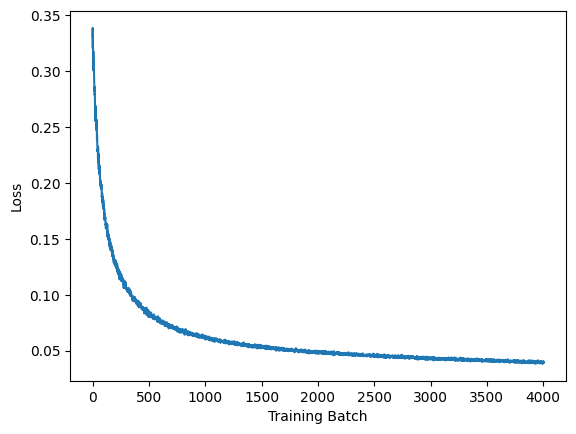

In [ ]:
from datasets import Dataset, load_dataset, interleave_datasets
from torch.utils.data import DataLoader
import gc
import numpy as np


## ===== WHICH MODELS? ===== ##

sae_to_train = sae_vit
clip_to_train_on = model_vit


## =====  HYPERPARAMETERS   ===== ##

batch_size = 256
learning_rate = 1e-4
l1_strength = 6e-1
num_epochs = 1

# Dataset_take_size tells you how many images to train on (i.e. the size of an epoch)
taking_from_dataset = False # turning this off will train on the entire dataset
dataset_take_size = 60000
dataset_size = 256234 * 4

loss_criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(sae_to_train.parameters(), lr=learning_rate)

## ===== DATA PREPROCESSING ===== ##


ds_0 = load_dataset("fzhu22/imagenet1k-vit-preproc-0", streaming=True, split = "train")
ds_2 = load_dataset("fzhu22/imagenet1k-vit-preproc-2", streaming=True, split = "train")
ds_3 = load_dataset("fzhu22/imagenet1k-vit-preproc-3", streaming=True, split = "train")
ds_4 = load_dataset("fzhu22/imagenet1k-vit-preproc-4", streaming=True, split = "train")
train_dataset = interleave_datasets([ds_0, ds_2, ds_3, ds_4])
computed_num_batches = -(dataset_size // -batch_size)


"""
computed_num_batches = None
if taking_from_dataset:
  train_dataset = load_dataset("fzhu22/imagenet1k-vit-preproc-2", streaming=True, split = "train").take(dataset_take_size)
  computed_num_batches = -(dataset_take_size // -batch_size) # ceiling division computation trick
else:
  train_dataset = load_dataset("fzhu22/imagenet1k-vit-preproc-2", streaming=True, split = "train")
  computed_num_batches = -(dataset_size // -batch_size)
"""

train_dataset = train_dataset.with_format("torch")

# Creates a dataloader
train_loader_batches = DataLoader(
    train_dataset,
    batch_size = batch_size,
    num_workers = 1,
    pin_memory = True,
    prefetch_factor = 2,
    # could use workers, pin memory, etc. but idk what they do
)

## ===== SET UP MODELS AND ENSURE CORRECT DEVICES ===== ##
clip_to_train_on.eval().requires_grad_(False)
clip_device = next(clip_to_train_on.parameters()).device

print("Loaded model on device ", clip_device)
print("Loaded SAE on device ", next(sae_to_train.parameters()).device)
# TODO: ADD CHECK TO MAKE SURE THE HOOKS ARE IN THERE AND MOVE SAE TO SAME DEVICE AS CLIP


## ========== TRAINING LOOP ========== ##

loss_history = []

for epoch in range(num_epochs):
  i=0

  for img_batch in train_loader_batches:

    if (i % 200 == 0):
      print(f"batch {i} of {computed_num_batches} •  avg-loss = {sum(loss_history[-200:]) / 200}")
      torch.cuda.empty_cache()
    elif (i % 10 == 0):
      print("batch ", i, " of ", computed_num_batches, "loss: ", loss_history[-1].item())
    i += 1

    # img_batch has dict_keys(['pixels', 'shape', 'filename'])
    img_arrays = [np.frombuffer(img_bytes, dtype=np.float32).reshape(3, 224, 224) for img_bytes in img_batch["pixels"]]
    img_batch = torch.from_numpy(np.stack(img_arrays)).to(clip_device)

    # run the forward pass (grad should be off)
    dummy_out = clip_to_train_on.encode_image(img_batch)

    # Get input data and run preds
    sae_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)
    del activations["vit_hook"]
    sae_preds, latents = sae_vit(sae_y)
    # Define loss with l1 regularization (needs to be how strong?)
    loss = loss_criterion(sae_preds, sae_y) + l1_strength * latents.abs().mean()
    del sae_y
    loss_history.append(loss)
    # Compute grads and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"epoch {epoch+1}/{num_epochs}  •  avg-loss = {sum(loss_history[-computed_num_batches:]) / computed_num_batches:.4f}")

loss_history = [item.item() for item in loss_history]
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.show()

History:

```
=== Avg loss 0.0310, sparsity 82.8% ===
batch_size = 8
learning_rate = 2e-4
l1_strength = 2e-2
num_epochs = 3
dataset_take_size = 5000

```



### Loop V2 With Neuron Resampling

1. At training steps 25,000, 50,000, 75,000 and 100,000, identify which neurons have not fired in any of the previous 12,500 training steps.
Compute the loss for the current model on a random subset of 819,200 inputs.
2. Assign each input vector a probability of being picked that is proportional to the square of the autoencoder’s loss on that input.
3. For each dead neuron sample an input according to these probabilities. Renormalize the input vector to have unit L2 norm and set this to be the dictionary vector for the dead autoencoder neuron.
4. For the corresponding encoder vector, renormalize the input vector to equal the average norm of the encoder weights for alive neurons × 0.2. Set the corresponding encoder bias element to zero.
5. Reset the Adam optimizer parameters for every modified weight and bias term.


In [ ]:
expansion_factor = 16
in_size_vit = 768

sae_vit = LinearSAE(in_size=in_size_vit,  latent_size=(in_size_vit * expansion_factor)).to(vit_device)
# goes in after LayerNorm(768)
print(sae_vit)
print("SAE VIT Encode Weights Shape: ", sae_vit.encode.weight.shape)


LinearSAE(
  (encode): Linear(in_features=768, out_features=24576, bias=False)
  (decode): Linear(in_features=24576, out_features=768, bias=False)
)
SAE VIT Encode Weights Shape:  torch.Size([24576, 768])


In [ ]:
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader
import gc
import numpy as np


## ===== WHICH MODELS? ===== ##

sae_to_train = sae_vit
clip_to_train_on = model_vit

## =====  HYPERPARAMETERS   ===== ##

batch_size = 16
learning_rate = 1e-4
l1_strength = 6e-1
num_epochs = 1

# Dataset_take_size tells you how many images to train on (i.e. the size of an epoch)
taking_from_dataset = False # turning this off will train on the entire dataset
dataset_take_size = 60000
dataset_size = 256234

loss_criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(sae_to_train.parameters(), lr=learning_rate)

## ===== DATA PREPROCESSING ===== ##


computed_num_batches = None
if taking_from_dataset:
  train_dataset = load_dataset("fzhu22/imagenet1k-vit-preproc-2", streaming=True, split = "train").take(dataset_take_size)
  computed_num_batches = -(dataset_take_size // -batch_size) # ceiling division computation trick
else:
  train_dataset = load_dataset("fzhu22/imagenet1k-vit-preproc-2", streaming=True, split = "train")
  computed_num_batches = -(dataset_size // -batch_size)

train_dataset = train_dataset.with_format("torch")

# Creates a dataloader
train_loader_batches = DataLoader(
    train_dataset,
    batch_size = batch_size,
    num_workers = 2,
    pin_memory = True,
    prefetch_factor = 2,
    # could use workers, pin memory, etc. but idk what they do
)

## ===== SET UP MODELS AND ENSURE CORRECT DEVICES ===== ##
clip_to_train_on.eval().requires_grad_(False)
clip_device = next(clip_to_train_on.parameters()).device

print("Loaded model on device ", clip_device)
print("Loaded SAE on device ", next(sae_to_train.parameters()).device)
# TODO: ADD CHECK TO MAKE SURE THE HOOKS ARE IN THERE AND MOVE SAE TO SAME DEVICE AS CLIP


## ========== TRAINING LOOP ========== ##

loss_history = []

# params for neuron resampling
resample_init_steps = [300 * i for i in range(100)]
resample_tracking_length = 200
resample_firing_threshold = 1e-6

for epoch in range(num_epochs):
  i=0
  resample_batch_ranges = [(i, i+resample_tracking_length) for i in resample_init_steps]
  resample_mask = torch.zeros((in_size_vit * expansion_factor,), dtype = torch.bool).to(vit_device)
  resample_steps = 0

  for img_batch in train_loader_batches:

    if (i % 200 == 0):
      print(f"batch {i} of {computed_num_batches} •  avg-loss = {sum(loss_history[-200:]) / 200}")
      torch.cuda.empty_cache()
    elif (i % 10 == 0):
      print("batch ", i, " of ", computed_num_batches, "loss: ", loss_history[-1].item())
    i += 1

    # img_batch has dict_keys(['pixels', 'shape', 'filename'])
    img_arrays = [np.frombuffer(img_bytes, dtype=np.float32).reshape(3, 224, 224) for img_bytes in img_batch["pixels"]]
    img_batch = torch.from_numpy(np.stack(img_arrays)).to(clip_device)

    # run the forward pass (grad should be off)
    with torch.no_grad():
      dummy_out = clip_to_train_on.encode_image(img_batch)

    # Get input data and run preds
    sae_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)
    del activations["vit_hook"]
    sae_preds, latents = sae_vit(sae_y)

    # Define loss with l1 regularization (needs to be how strong?)
    loss = loss_criterion(sae_preds, sae_y) + l1_strength * latents.abs().mean()
    del sae_y
    loss_history.append(loss)

    # Compute grads and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### NEURON RESAMPLING ###
    for a, b in resample_batch_ranges:
      if i == a:

        """
        sae_vit.encode.weight.data[1,:] =0
        sae_vit.decode.weight.data[:,1] = 0
        if 'exp_avg' in optim_encode_state:
          optim_encode_state['exp_avg'][1,:] = 0
        if 'exp_avg_sq' in optim_encode_state:
          optim_encode_state['exp_avg_sq'][1,:] = 0

        optim_decode_state = optimizer.state[sae_vit.decode.weight]
        if 'exp_avg' in optim_decode_state:
          optim_decode_state['exp_avg'][:,1] = 0
        if 'exp_avg_sq' in optim_decode_state:
          optim_decode_state['exp_avg_sq'][:,1] = 0
        """

        resample_mask = torch.zeros((in_size_vit * expansion_factor,), dtype=torch.bool).to(vit_device)
        resample_window = 0
        print(f"Starting resampling window at batch {i}")

      elif (a < i < b) or (b < i <= (b+100)):
        resample_mask_step_batch = (latents > resample_firing_threshold).to(vit_device)
        resample_mask_step = torch.any(resample_mask_step_batch, dim=0)
        resample_mask = resample_mask | resample_mask_step
        if (i - a) % 20 == 0:
          print(f"Batch {i}: {resample_mask.sum().item()}/{len(resample_mask)} neurons have fired")

      elif i == b:
        with torch.no_grad():
          # run steps 2-6
          dead_neurons = ~resample_mask
          num_dead = dead_neurons.sum()

          encode_dead_mask = dead_neurons.reshape((-1, 1))
          decode_dead_mask = dead_neurons.reshape((1, -1))
          # simple implementation: reinitialize the dead neurons randomly
          # encode is shape (in, latent) so i want to reshape dead_neurons to shape (1, latent) and broadcast
          sae_vit.encode.weight.data = (sae_vit.encode.weight.data * resample_mask.reshape(-1, 1)) + (encode_dead_mask * torch.randn_like(sae_vit.encode.weight.data)*0.05)
          sae_vit.decode.weight.data = (sae_vit.decode.weight.data * resample_mask.reshape(1, -1)) + (decode_dead_mask * torch.randn_like(sae_vit.decode.weight.data)*0.05)
          print("Successfully reinitialized weights for ", num_dead.item(), " neurons.")

          # Reset optimizer states
          optim_encode_state = optimizer.state[sae_vit.encode.weight]
          if 'exp_avg' in optim_encode_state:
            optim_encode_state['exp_avg'][dead_neurons] = 0
          if 'exp_avg_sq' in optim_encode_state:
            optim_encode_state['exp_avg_sq'][dead_neurons] = 0

          optim_decode_state = optimizer.state[sae_vit.decode.weight]
          if 'exp_avg' in optim_decode_state:
            optim_decode_state['exp_avg'][:, dead_neurons] = 0
          if 'exp_avg_sq' in optim_decode_state:
            optim_decode_state['exp_avg_sq'][:, dead_neurons] = 0

          print("Successfully reinitialized optimizer state for ", num_dead, " neurons.")

          #resample_mask = torch.zeros((in_size_vit * expansion_factor,), dtype=torch.bool).to(vit_device)
          #resample_window = 0



  print(f"epoch {epoch+1}/{num_epochs}  •  avg-loss = {sum(loss_history[-computed_num_batches:]) / computed_num_batches:.4f}")

loss_history = [item.item() for item in loss_history]
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.show()

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Loaded model on device  cuda:0
Loaded SAE on device  cuda:0
batch 0 of 16015 •  avg-loss = 0.0
batch  10  of  16015 loss:  0.03871753811836243
Batch 20: 19625/24576 neurons have fired
batch  20  of  16015 loss:  0.041073352098464966
batch  30  of  16015 loss:  0.04743821173906326
Batch 40: 21053/24576 neurons have fired
batch  40  of  16015 loss:  0.03772131726145744
batch  50  of  16015 loss:  0.039561815559864044
Batch 60: 21648/24576 neurons have fired
batch  60  of  16015 loss:  0.041530586779117584
batch  70  of  16015 loss:  0.03767244517803192
Batch 80: 21989/24576 neurons have fired
batch  80  of  16015 loss:  0.038098178803920746
batch  90  of  16015 loss:  0.03817032277584076
Batch 100: 22264/24576 neurons have fired
batch  100  of  16015 loss:  0.03988239914178848
batch  110  of  16015 loss:  0.04391184076666832
Batch 120: 22511/24576 neurons have fired
batch  120  of  16015 loss:  0.043827399611473083
batch  130  of  16015 loss:  0.03471854701638222
Batch 140: 22718/24576 n

KeyboardInterrupt: 

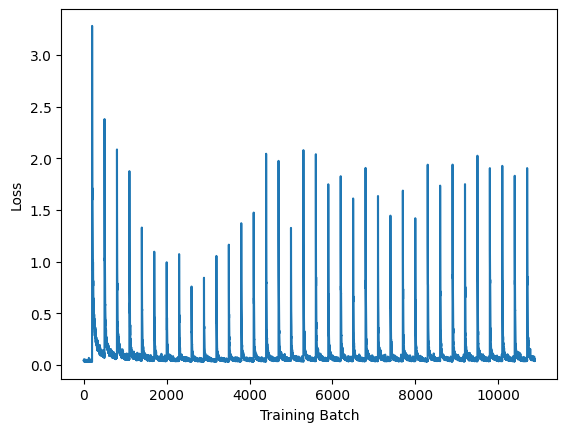

In [ ]:
loss_history = [item.item() for item in loss_history]
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.show()

**Save Model**

In [ ]:
save_path = f'sae_vit-exp{expansion_factor}-lr{learning_rate}-l1{l1_strength}-epochs1-splits4.pth'
torch.save(sae_vit.state_dict(), save_path)

**Load Model**

In [ ]:
save_path = 'sae_vit-exp32-lr0.0001-l10.6-epochs1.pth'
sae_vit.load_state_dict(torch.load(save_path, weights_only=True))

<All keys matched successfully>

## Evaluating Sparsity

In [ ]:
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader


def population_sparsity(latent_activations, threshold=1e-6):
  active = (latent_activations > threshold).astype(float)
  return active.mean(axis=1).mean()

def lifetime_sparsity(latent_activations, threshold=1e-6):
  active = (latent_activations > threshold).astype(float)
  sparsity_per_unit = active.mean(axis=0)
  return sparsity_per_unit, float(sparsity_per_unit.mean())

def return_active_neurons(latent_activations, threshold=1e-6):
  active = (latent_activations > threshold)
  return

check_size = 500
sparsity_check_ds = load_dataset("fzhu22/imagenet1k-vit-preproc-0", streaming=True, split = "train").take(check_size)

big_loader = torch.utils.data.DataLoader(
    sparsity_check_ds,
    batch_size=check_size,
    shuffle=False
)

all_inputs = next(iter(big_loader))
img_arrays = [np.frombuffer(img_bytes, dtype=np.float32).reshape(3, 224, 224) for img_bytes in all_inputs["pixels"]]
all_inputs = torch.from_numpy(np.stack(img_arrays)).to(clip_device)


sae_vit.eval()
with torch.no_grad():
  dummy_out = clip_to_train_on.encode_image(all_inputs)
  # del dummy_out
  sae_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)
  sae_preds, latent = sae_vit(sae_y)
  # latent = torch.relu(latent)

latent = latent.cpu().numpy()
pop_sparse = population_sparsity(latent)
sparsity_per_unit, avg_life_sparse = lifetime_sparsity(latent)

#uncomment if want to print out individual unit inactivity
#print("Lifetime sparsity per unit:")
#for j, sp in enumerate(sparsity_per_unit):
#    print(f"  Unit {j:2d}: {100*sp:.1f}% inactive")

print(f"Mean lifetime sparsity: {100*avg_life_sparse:.1f}%")
print(f"Population sparsity: {pop_sparse}")
if training_history is None:
  training_history = []

training_history.append(
    {"batch_size": batch_size,
    "learning_rate": learning_rate,
    "l1_strength": l1_strength,
    "num_epochs": num_epochs,
    "dataset_take_size": dataset_take_size,
    "pop_sparse": pop_sparse})



Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Mean lifetime sparsity: 19.8%
Population sparsity: 0.19755045572916669


Plot lifetime sparsity distribution

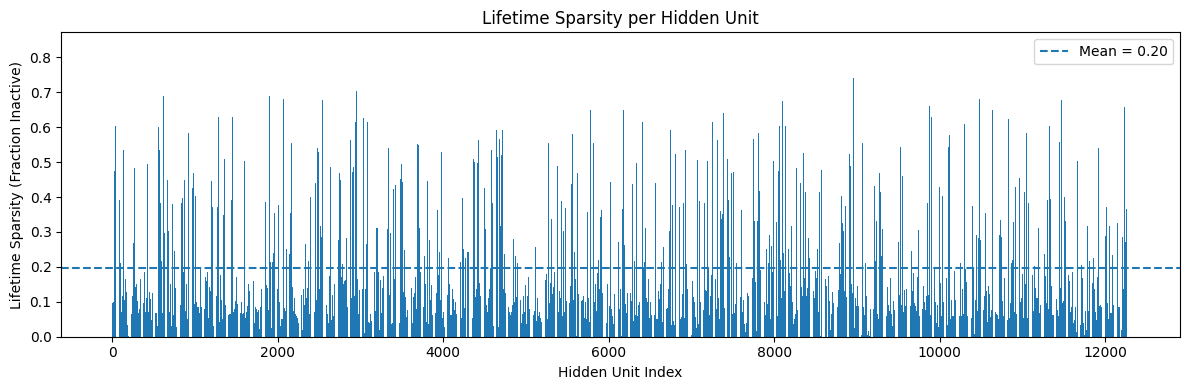

In [ ]:
H = len(sparsity_per_unit)
unit_indices = np.arange(H)

plt.figure(figsize=(12, 4))
plt.bar(unit_indices, sparsity_per_unit)
plt.axhline(sparsity_per_unit.mean(), linestyle='--',
            label=f"Mean = {sparsity_per_unit.mean():.2f}")
plt.xlabel("Hidden Unit Index")
plt.ylabel("Lifetime Sparsity (Fraction Inactive)")
plt.title("Lifetime Sparsity per Hidden Unit")
plt.legend()
plt.tight_layout()
plt.show()

We also want to plot a histogram of hidden unit sparsities -- how are they clustered?

<ipython-input-30-20f2854db416>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


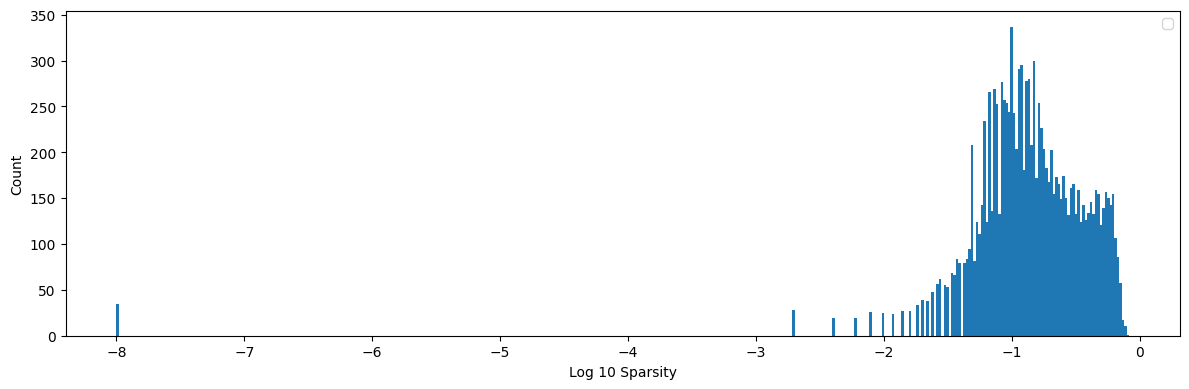

In [ ]:
#for j, sp in enumerate(sparsity_per_unit):
#    print(f"  Unit {j:2d}: {100*sp:.1f}% inactive")

# Sparsity_per_unit is [95, 63, 54, etc.]
epsilon = 1e-8
plt.figure(figsize=(12, 4))
x_sorted = sorted(sparsity_per_unit)
for i in range(len(x_sorted)):
  x_sorted[i] += epsilon

n_bins = H//30


plt.hist(np.log10(x_sorted), bins = n_bins)
plt.xlabel("Log 10 Sparsity")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

### Top Image Vis

In [ ]:
def top_k_images(sae_model, dataset, device, k=5, batch_size=32, n=10):

  hidden_states = []
  def hook_fn(module, input, output):
    hidden_states.append(output)

  # Removes all hooks from the ViT
  for h in list(getattr(model_vit, '_sae_hooks', [])):
    h.remove()

  model_vit._sae_hooks = []

  # Registers a forward hook for every residual block
  for blk in model_vit.visual.transformer.resblocks:
    h = blk.register_forward_hook(hook_fn)
    model_vit._sae_hooks.append(h)

  # Sets up a dataloader from the dataset that was passed in
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  print("Using batch_size=", batch_size, "=> will process", len(loader) * batch_size, "images total")

  # Sets SAE to eval mode and moves to correct device
  sae_model.eval()
  sae_model.to(device)

  activations = []
  images = []
  latents = []

  vit_dtype  = model_vit.visual.conv1.weight.dtype
  with torch.no_grad():

    # For each batch in the dataloader:
    for x in loader:
      x = x.to(device)

      for img in x.cpu():
        #save raw images for displaying top k later
        images.append(img)


      x_vit = x.to(vit_dtype)
      hidden_states.clear()

      # Runs through the ViT
      _ = model_vit.visual(x_vit)

      # last hidden state
      h = hidden_states[-1]
      h = h.permute(1, 0, 2)

      # computes...?
      feats = h.mean(dim=1)
      feats = feats.float()
      feats = feats.to(device)
      _, z = sae_model(feats)

      latents.append(z.cpu())
      scores = torch.sum(torch.abs(z), dim=1)
      activations.append(scores.cpu())

  # Concatinates all the scores from each batch together in `activations`
  activations = torch.cat(activations)

  images = torch.stack(images, dim=0)
  z_matrix = torch.cat(latents, dim=0)

  # Takes the top k for the parameter k passed into this function
  topk_vals, topk_idx = torch.topk(activations, k)
  selected_z = z_matrix[topk_idx]
  unit_means = selected_z.abs().mean(dim=0)
  top_unit_vals, top_unit_idx = torch.topk(unit_means, n)

  return images[topk_idx], topk_vals, top_unit_vals, top_unit_idx

def show_image_grid(imgs, titles=None, nrow=5):
  k = imgs.shape[0]
  ncol = int(np.ceil(k / nrow))
  fig, axes = plt.subplots(ncol, nrow, figsize=(nrow*2, ncol*2))
  axes = axes.flatten()

  for i in range(k):
    img = imgs[i]
    if img.dim() == 2:
            img = img.unsqueeze(0).repeat(3,1,1)
    img = img.permute(1,2,0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')
    if titles is not None:
      axes[i].set_title(f"{titles[i]:.2f}", fontsize=8)
    for j in range(k, len(axes)):
      axes[j].axis('off')
  plt.show()

def show_active_units(top_unit_vals, top_unit_idx):
  plt.bar(top_unit_idx.cpu().numpy().astype(str),
          top_unit_vals.cpu().numpy())
  plt.xlabel('Latent Unit Index')
  plt.ylabel('Mean |Activation|')
  plt.title('Top 10 Most Active SAE Units')
  plt.show()

In [ ]:
del x_sorted


Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Using batch_size= 20 => will process 500 images total


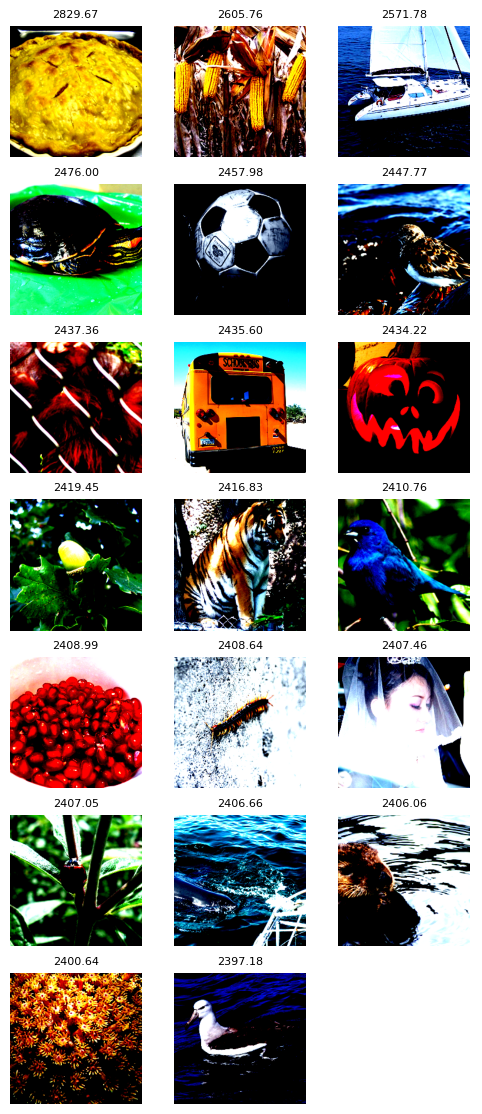

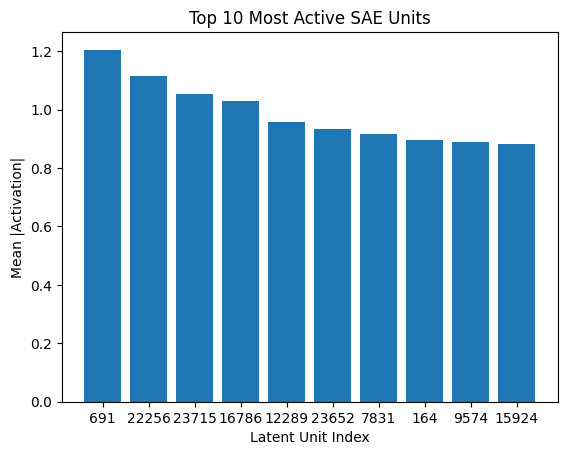

In [ ]:
check_size_visualization = 1000

# iterabledataset --> dataloader --> each batch in dataloader has dict_keys(['pixels', 'shape', 'filename'])


image_vis_ds = load_dataset("fzhu22/imagenet1k-vit-preproc-0", streaming=True, split = "train").take(check_size)

big_loader = torch.utils.data.DataLoader(
    image_vis_ds,
    batch_size=check_size_visualization
)

vis_inputs = next(iter(big_loader))
img_arrays = [np.frombuffer(img_bytes, dtype=np.float32).reshape(3, 224, 224) for img_bytes in vis_inputs["pixels"]]
vis_inputs = torch.from_numpy(np.stack(img_arrays)).to(clip_device)


top_imgs, top_scores, top_unit_vals, top_unit_idx = top_k_images(sae_vit, vis_inputs, vit_device, k=20, batch_size=20)
show_image_grid(top_imgs, titles=top_scores.tolist(), nrow=3)
show_active_units(top_unit_vals, top_unit_idx)

Random feature visualization

### Random Feature Visualization

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/309 [00:00<?, ?it/s]

Found 12288 active neurons out of 12288 total neurons


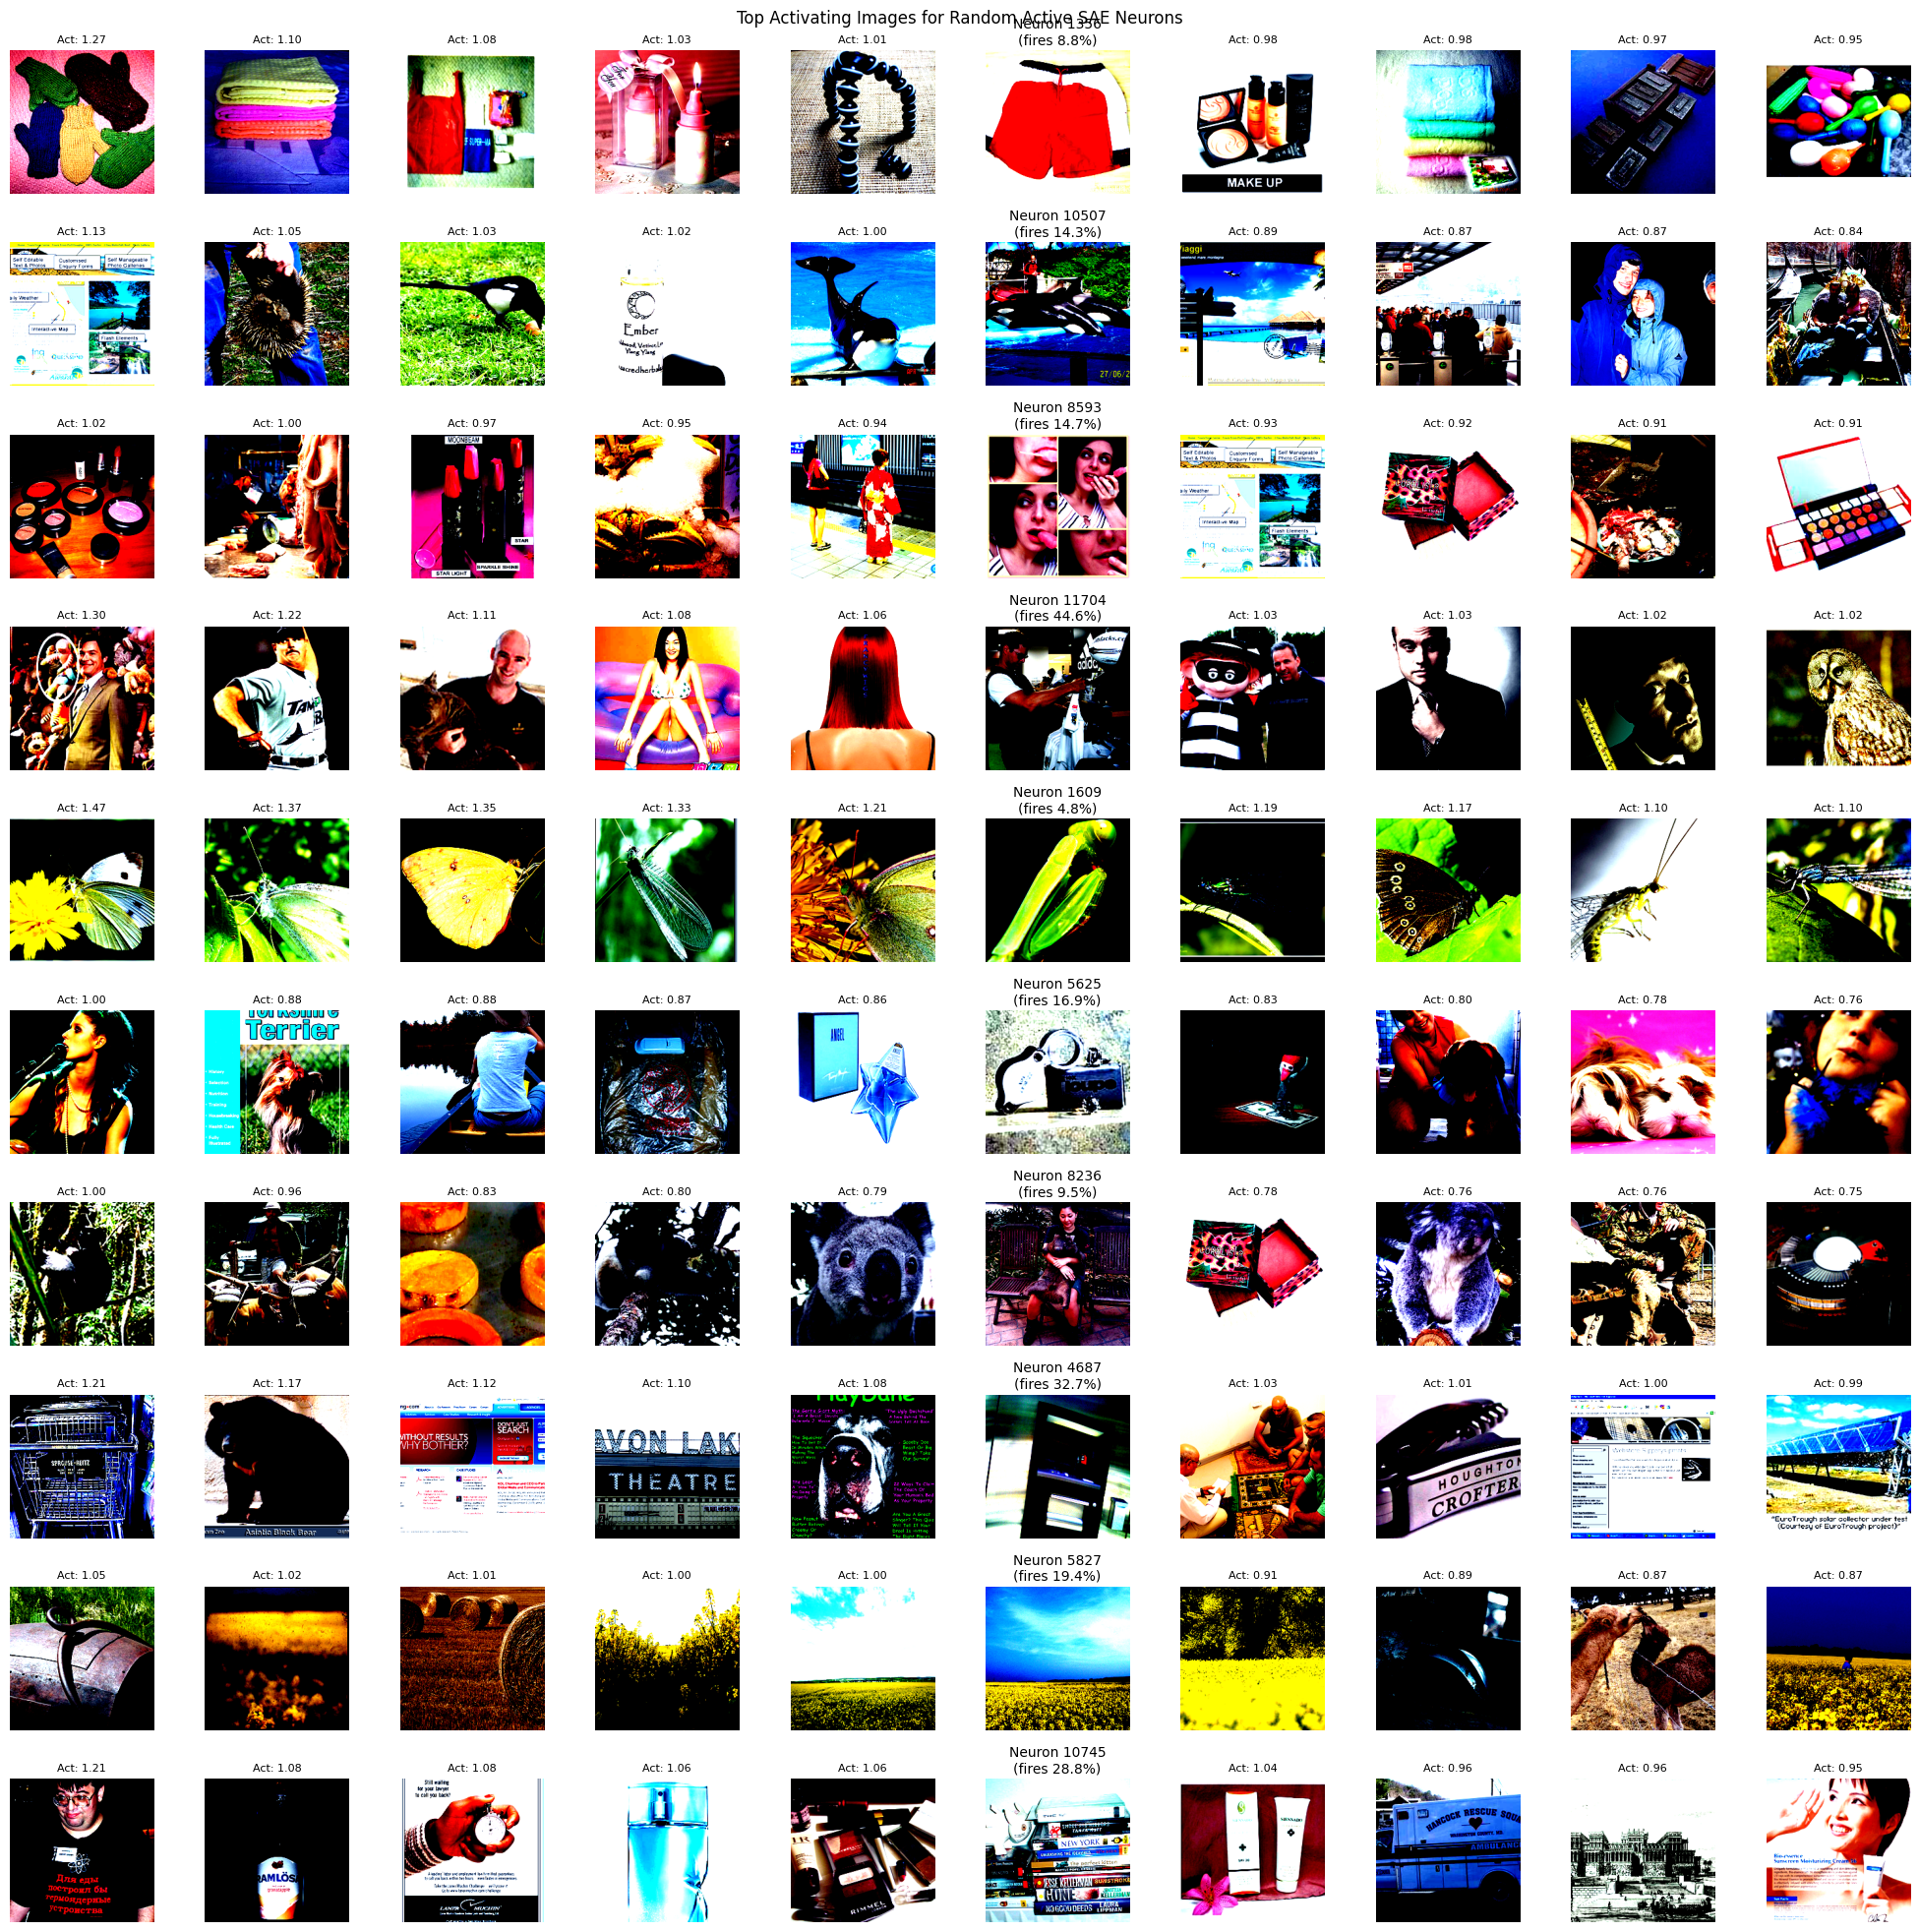

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
import random

def visualize_k_images(sae, clip_model, dataset, device, num_neurons=10, k=6, n=1000, batch_size=16, threshold=1e-6):
    """
    Visualize top-k activating images for randomly sampled SAE neurons (only sampling from active neurons).

    Args:
        sae: The SAE model
        clip_model: The CLIP model to extract features
        dataset: The streaming dataset
        device: torch device
        num_neurons: Number of neurons to sample
        k: Number of top images per neuron
        n: Total number of images to process
        batch_size: Batch size for processing
        threshold: Minimum activation threshold for considering a neuron "active"

    Returns:
        visualized_images: List of tuples (neuron_index, [top_k_images])
    """
    # Set up hook to capture activations
    activations = {}

    def hook_fn(name):
        def hook(model, input, output):
            activations[name] = output
        return hook

    # Register hook on the appropriate layer
    hook_layer = clip_model.visual.ln_post
    handle = hook_layer.register_forward_hook(hook_fn("vit_hook"))

    try:
        # Create dataloader
        dataloader = DataLoader(dataset, batch_size=batch_size)

        # Storage for all activations and images
        all_images = []
        all_latents = []

        # Process images
        sae.eval()
        clip_model.eval()

        images_processed = 0

        # First pass: collect all activations
        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                if images_processed >= n:
                    break

                # Process image batch
                img_arrays = [np.frombuffer(img_bytes, dtype=np.float32).reshape(3, 224, 224)
                             for img_bytes in batch["pixels"]]
                img_batch = torch.from_numpy(np.stack(img_arrays)).to(device)

                # Get CLIP features
                _ = clip_model.encode_image(img_batch)
                clip_features = activations["vit_hook"].type(sae.encode.weight.dtype)

                # Get SAE latent activations
                _, latents = sae(clip_features)

                # Store images and activations
                for i in range(len(img_batch)):
                    if images_processed >= n:
                        break
                    all_images.append(img_arrays[i])
                    all_latents.append(latents[i].cpu().numpy())
                    images_processed += 1

        # Convert to numpy array for easier processing
        all_latents = np.stack(all_latents)  # Shape: [n_images, n_neurons]

        # Find active neurons (those that fire above threshold)
        neuron_activity = (all_latents > threshold).mean(axis=0)  # Fraction of time each neuron is active
        active_neurons = np.where(neuron_activity > 0)[0]  # Neurons that fire at least once

        print(f"Found {len(active_neurons)} active neurons out of {all_latents.shape[1]} total neurons")

        if len(active_neurons) == 0:
            print(f"Warning: No neurons fire above threshold {threshold}")
            return []

        # Sample from active neurons only
        if len(active_neurons) < num_neurons:
            print(f"Warning: Only {len(active_neurons)} neurons are active, sampling all of them")
            sampled_neurons = active_neurons.tolist()
        else:
            sampled_neurons = random.sample(active_neurons.tolist(), num_neurons)

        # Find top-k images for each sampled neuron
        visualized_images = []

        for neuron_idx in sampled_neurons:
            neuron_activations = all_latents[:, neuron_idx]
            top_k_indices = np.argsort(neuron_activations)[-k:][::-1]  # Get top k indices
            top_k_images = [all_images[idx] for idx in top_k_indices]
            top_k_activations = neuron_activations[top_k_indices]

            # Include firing rate info
            firing_rate = (neuron_activations > threshold).mean()
            visualized_images.append((neuron_idx, top_k_images, top_k_activations, firing_rate))

        return visualized_images

    finally:
        # Clean up hook
        handle.remove()


def plot_neuron_activations(visualized_images, num_cols=6):
    """
    Plot the top activating images for each neuron.

    Args:
        visualized_images: Output from visualize_k_images
        num_cols: Number of columns (images per neuron)
    """
    num_neurons = len(visualized_images)

    fig, axes = plt.subplots(num_neurons, num_cols, figsize=(num_cols * 2, num_neurons * 2))

    if num_neurons == 1:
        axes = axes.reshape(1, -1)

    for row, neuron_data in enumerate(visualized_images):
        # Handle both old format (3 elements) and new format (4 elements with firing rate)
        if len(neuron_data) == 4:
            neuron_idx, images, activations, firing_rate = neuron_data
        else:
            neuron_idx, images, activations = neuron_data
            firing_rate = None

        for col, (img, activation) in enumerate(zip(images, activations)):
            ax = axes[row, col]

            # Transpose image from CHW to HWC for display
            img_display = np.transpose(img, (1, 2, 0))

            # Clip values to [0, 1] range for display
            img_display = np.clip(img_display, 0, 1)

            ax.imshow(img_display)
            ax.set_title(f"Act: {activation:.2f}", fontsize=8)
            ax.axis('off')

        # Add neuron index label on the left, with firing rate if available
        if firing_rate is not None:
            label = f"Neuron {neuron_idx}\n(fires {firing_rate*100:.1f}%)"
        else:
            label = f"Neuron {neuron_idx}"
        axes[row, num_cols//2].set_title(label, fontsize=10, pad=5)

    plt.suptitle("Top Activating Images for Random Active SAE Neurons", fontsize=12)
    plt.tight_layout()
    plt.show()


# Usage example:
check_size_visualization = 20000

image_vis_ds = load_dataset("fzhu22/imagenet1k-vit-preproc-0", streaming=True, split="train").take(check_size_visualization)
image_vis_ds = image_vis_ds.with_format("torch")

k = 10

# Call the function (now only samples from active neurons)
visualized_images = visualize_k_images(
    sae_vit,
    model_vit,
    image_vis_ds,
    vit_device,
    num_neurons=10,
    k=k,
    n=check_size_visualization,
    batch_size=16,
    threshold=1e-6  # Only sample from neurons that fire above this threshold
)

# Visualize the results
plot_neuron_activations(visualized_images, num_cols = k)

In [ ]:
import pprint
pprint.pp(training_history)
# prev expansion factor was 4; increasing to 16 now

[]


In [ ]:
import pprint
pprint.pp(training_history)

[{'batch_size': 16,
  'learning_rate': 0.0002,
  'l1_strength': 0.5,
  'num_epochs': 1,
  'dataset_take_size': 60000,
  'pop_sparse': np.float64(0.13744677734375)}]


archive:

```
[{'batch_size': 16,
  'learning_rate': 0.0002,
  'l1_strength': 0.02,
  'num_epochs': 4,
  'dataset_take_size': 10000},
 {'batch_size': 16,
  'learning_rate': 0.0002,
  'l1_strength': 0.05,
  'num_epochs': 3,
  'dataset_take_size': 10000},
 {'batch_size': 16,
  'learning_rate': 0.0002,
  'l1_strength': 0.1,
  'num_epochs': 3,
  'dataset_take_size': 20000},
 {'batch_size': 16,
  'learning_rate': 0.0002,
  'l1_strength': 0.5,
  'num_epochs': 3,
  'dataset_take_size': 50000,
  'pop_sparse': np.float64(0.3074173177083333)}]
```

## Comparative evals

In [ ]:
print(sae_vit, sae_rn50)

In [ ]:
def extract_activations_both_models(vit_sae, vit_clip, resnet_sae, resnet_clip, dataset, n_images=5000):
    """Extract activations from both SAEs on the same images"""
    dataset = dataset.shuffle().take(n_images)
    dataloader = DataLoader(
      datset,
      batch_size = batch_size,
      num_workers = 1,
      pin_memory = True,
      prefetch_factor = 2,
    )



    sae_vit.eval()
    with torch.no_grad():
      _ = vit_clip.encode_image(next(dataloader))
      _ = resnet_clip.encode_image(all_inputs)
      sae_vit_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)
      sae_rn50_y = activations["vit_hook"].type(sae_rn50.encode.weight.dtype)

      sae_preds, latent = sae_vit(sae_vit_y)
      sae_preds, latent = sae_rn50(sae_rn50_y)

  # latent = torch.relu(latent)

    # Process same images through both models
    # Return: images, vit_activations, resnet_activations


In [ ]:
check_size = 500
sparsity_check_ds = load_dataset("fzhu22/imagenet1k-vit-preproc-0", streaming=True, split = "train").take(check_size)

big_loader = torch.utils.data.DataLoader(
    sparsity_check_ds,
    batch_size=check_size,
    shuffle=False
)

all_inputs = next(iter(big_loader))
img_arrays = [np.frombuffer(img_bytes, dtype=np.float32).reshape(3, 224, 224) for img_bytes in all_inputs["pixels"]]
all_inputs = torch.from_numpy(np.stack(img_arrays)).to(clip_device)


sae_vit.eval()
with torch.no_grad():
  dummy_out = clip_to_train_on.encode_image(all_inputs)
  # del dummy_out
  sae_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)
  sae_preds, latent = sae_vit(sae_y)
  # latent = torch.relu(latent)

latent = latent.cpu().numpy()
pop_sparse = population_sparsity(latent)


# Training Loop for ResNet

In [ ]:
training_history = []
expansion_factor = 32
#in_size_vit = 768
in_size_rn50 = 1024

#sae_vit = LinearSAE(in_size=in_size_vit,  latent_size=(in_size_vit * expansion_factor)).to(vit_device)
# goes in after LayerNorm(768)
sae_rn50 = LinearSAE(in_size=1024, latent_size=(in_size_rn50 * expansion_factor)).to(resnet_device) # goes in after AttnPool (projecting down to 1024)

In [ ]:
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader
import gc
import numpy as np


## ===== WHICH MODELS? ===== ##

sae_to_train = sae_rn50
clip_to_train_on = model_resnet

## =====  HYPERPARAMETERS   ===== ##

batch_size = 16
learning_rate = 2e-4
l1_strength = 5e-1
num_epochs = 1

# Dataset_take_size tells you how many images to train on (i.e. the size of an epoch)
taking_from_dataset = True # turning this off will train on the entire dataset
dataset_take_size = 60000
dataset_size = 256234

loss_criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(sae_to_train.parameters(), lr=learning_rate)

## ===== DATA PREPROCESSING ===== ##

# currently taking 5000 from imagenet. Expecting to scale up.

computed_num_batches = None
if taking_from_dataset:
  train_dataset = load_dataset("fzhu22/imagenet1k-vit-preproc-0", streaming=True, split = "train").take(dataset_take_size)
  computed_num_batches = -(dataset_take_size // -batch_size) # ceiling division computation trick
else:
  train_dataset = load_dataset("fzhu22/imagenet1k-vit-preproc-0", streaming=True, split = "train")
  computed_num_batches = -(dataset_size // -batch_size)

train_dataset = train_dataset.with_format("torch")

# Creates a dataloader
train_loader_batches = DataLoader(
    train_dataset,
    batch_size = batch_size,
    num_workers = 2,
    pin_memory = True,
    prefetch_factor = 2,
    # could use workers, pin memory, etc. but idk what they do
)

## ===== SET UP MODELS AND ENSURE CORRECT DEVICES ===== ##
clip_to_train_on.eval().requires_grad_(False)
clip_device = next(clip_to_train_on.parameters()).device

print("Loaded model on device ", clip_device)
print("Loaded SAE on device ", next(sae_to_train.parameters()).device)
# TODO: ADD CHECK TO MAKE SURE THE HOOKS ARE IN THERE AND MOVE SAE TO SAME DEVICE AS CLIP


## ========== TRAINING LOOP ========== ##

loss_history = []

for epoch in range(num_epochs):
  i=0

  for img_batch in train_loader_batches:

    if (i % 200 == 0):
      print(f"batch {i} of {computed_num_batches} •  avg-loss = {sum(loss_history[-200:]) / 200}")
      torch.cuda.empty_cache()
    elif (i % 10 == 0):
      print("batch ", i, " of ", computed_num_batches, "loss: ", loss_history[-1].item())
    i += 1

    # img_batch has dict_keys(['pixels', 'shape', 'filename'])
    img_arrays = [np.frombuffer(img_bytes, dtype=np.float32).reshape(3, 224, 224) for img_bytes in img_batch["pixels"]]
    img_batch = torch.from_numpy(np.stack(img_arrays)).to(clip_device)

    # run the forward pass (grad should be off)
    dummy_out = clip_to_train_on.encode_image(img_batch)

    # Get input data and run preds
    sae_y = activations["vit_hook"].type(clip.encode.weight.dtype)
    del activations["vit_hook"]
    sae_preds, latents = clip_to_train_on(sae_y)
    # Define loss with l1 regularization (needs to be how strong?)
    loss = loss_criterion(sae_preds, sae_y) + l1_strength * latents.abs().mean()
    del sae_y
    loss_history.append(loss)
    # Compute grads and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"epoch {epoch+1}/{num_epochs}  •  avg-loss = {sum(loss_history[-computed_num_batches:]) / computed_num_batches:.4f}")

loss_history = [item.item() for item in loss_history]
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.show()

# Deprecated Code (for reference if needed)

## (Deprecated) Old CIFAR-10 Training Loop

Notes from training:

- Sparsity 72.4%, training loss = 0.1037
  - batch_size = 16
  - learning_rate = 3e-4
  - l1_strength = 3e-3
  - num_epochs = ***1***
  - subset_division = 8

- Sparsity 65.7%, training loss 0.0079
  - batch_size = 16
  - learning_rate = 3e-4
  - l1_strength = 5e-3
  - num_epochs = 4
  - subset_division = 8


- Sparsity 52.8%, training loss 0.0194
  - Batch size 8
  - learning_rate = 3e-4,
  - l1_strength = 2e-2,
  - num_epochs = 4
  - subset_division = 8

In [ ]:
from torch.utils.data import Subset
import gc

## ===== WHICH MODELS? ===== ##

sae_to_train = sae_vit
clip_to_train_on = model_vit

## =====  HYPERPARAMETERS   ===== ##

batch_size = 8
learning_rate = 2e-4
l1_strength = 2e-2
num_epochs = 3

# subset_division tells dataloader what fraction of the train dataset to use
# (useful for testing a smaller training run)
subset_division = 8

loss_criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(sae_to_train.parameters(), lr=learning_rate)

## ===== DATA PREPROCESSING ===== ##

train_dataset = torchvision.datasets.CIFAR10(
    root="data", train=True, download=True, transform=vit_preprocess
    # runs the preprocess() function as a transform!     ^^^^
)

subset_size = len(train_dataset) // subset_division
indices = list(range(subset_size))
subset_train_dataset = Subset(train_dataset, indices)

train_loader_batches = torch.utils.data.DataLoader(
    subset_train_dataset,
    batch_size = batch_size,
    shuffle = True,
    # could use workers, pin memory, etc. but idk what they do
)

## ===== SET UP MODELS AND ENSURE CORRECT DEVICES ===== ##
clip_to_train_on.eval().requires_grad_(False)
clip_device = next(clip_to_train_on.parameters()).device

print("Loaded model on device ", clip_device)
print("Loaded SAE on device ", next(sae_to_train.parameters()).device)
# TODO: ADD CHECK TO MAKE SURE THE HOOKS ARE IN THERE AND MOVE SAE TO SAME DEVICE AS CLIP


## ========== TRAINING LOOP ========== ##

loss_history = []

for epoch in range(num_epochs):
  i=0

  # _ is the img labels. We don't care about them
  for img_batch, _ in train_loader_batches:

    if (i % 10 == 0):
      print("batch ", i, " of ", len(train_loader_batches))
    i += 1
    img_batch = img_batch.to(clip_device)

    # run the forward pass (grad should be off)
    dummy_out = clip_to_train_on.encode_image(img_batch)

    # Get input data and run preds
    sae_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)
    del activations["vit_hook"]
    sae_preds, latents = sae_vit(sae_y)
    # Define loss with l1 regularization (needs to be how strong?)
    loss = loss_criterion(sae_preds, sae_y) + l1_strength * latents.abs().mean()
    del sae_y
    loss_history.append(loss)
    # Compute grads and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    torch.cuda.empty_cache()
    gc.collect()

  print(f"epoch {epoch+1}/{num_epochs}  •  avg-loss = {sum(loss_history[-len(train_loader_batches):]) / len(train_loader_batches):.4f}")

loss_history = [item.item() for item in loss_history]
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.show()

Loaded model on device  cuda:0
Loaded SAE on device  cuda:0
batch  0  of  1563
batch  10  of  1563
batch  20  of  1563
batch  30  of  1563
batch  40  of  1563
batch  50  of  1563
batch  60  of  1563
batch  70  of  1563
batch  80  of  1563
batch  90  of  1563
batch  100  of  1563
batch  110  of  1563
batch  120  of  1563
batch  130  of  1563
batch  140  of  1563
batch  150  of  1563
batch  160  of  1563
batch  170  of  1563
batch  180  of  1563
batch  190  of  1563
batch  200  of  1563
batch  210  of  1563
batch  220  of  1563
batch  230  of  1563
batch  240  of  1563
batch  250  of  1563
batch  260  of  1563
batch  270  of  1563
batch  280  of  1563
batch  290  of  1563
batch  300  of  1563
batch  310  of  1563
batch  320  of  1563
batch  330  of  1563
batch  340  of  1563
batch  350  of  1563
batch  360  of  1563
batch  370  of  1563
batch  380  of  1563
batch  390  of  1563
batch  400  of  1563
batch  410  of  1563
batch  420  of  1563
batch  430  of  1563
batch  440  of  1563
batch 

KeyboardInterrupt: 

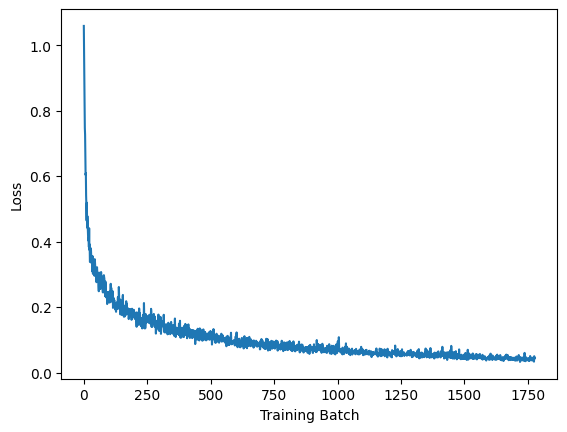

In [ ]:
loss_history = [item.item() for item in loss_history]
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.show()

Test on validation set:

In [ ]:
## TODO ##

"""val_dataset = torchvision.datasets.CIFAR10(
    root="data", train=True, download=True, transform=vit_preprocess
    # runs the preprocess() function as a transform!     ^^^^
)"""


## (Deprecated) Evaluating Sparsity for CIFAR-10

In [ ]:
def population_sparsity(latent_activations, threshold=1e-6):
  active = (latent_activations > threshold).astype(float)
  return active.mean(axis=1).mean()

def lifetime_sparsity(latent_activations, threshold=1e-6):
  active = (latent_activations > threshold).astype(float)
  sparsity_per_unit = active.mean(axis=0)
  return sparsity_per_unit, float(sparsity_per_unit.mean())

Use one big batch of all the data

In [ ]:
subset_size = len(train_dataset) // 50
indices = list(range(subset_size))
subset = Subset(train_dataset, indices)

big_loader = torch.utils.data.DataLoader(
    subset,
    batch_size=subset_size,
    shuffle=False
)
all_inputs, all_labels = next(iter(big_loader))
print(all_inputs.shape)

Evaluate population and lifetime sparsity

In [ ]:
sae_vit.eval()
with torch.no_grad():
  dummy_out = clip_to_train_on.encode_image(all_inputs)
  # del dummy_out
  sae_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)
  sae_preds, latent = sae_vit(sae_y)
  # latent = torch.relu(latent)

latent = latent.cpu().numpy()
pop_sparse = population_sparsity(latent)
sparsity_per_unit, avg_life_sparse = lifetime_sparsity(latent)

#uncomment if want to print out individual unit inactivity
#print("Lifetime sparsity per unit:")
#for j, sp in enumerate(sparsity_per_unit):
#    print(f"  Unit {j:2d}: {100*sp:.1f}% inactive")

print(f"Mean lifetime sparsity: {100*avg_life_sparse:.1f}%")
print(f"Population sparsity: {pop_sparse}")

Mean lifetime sparsity: 83.4%
Population sparsity: 0.8343580729166666


Plot lifetime sparsity distribution

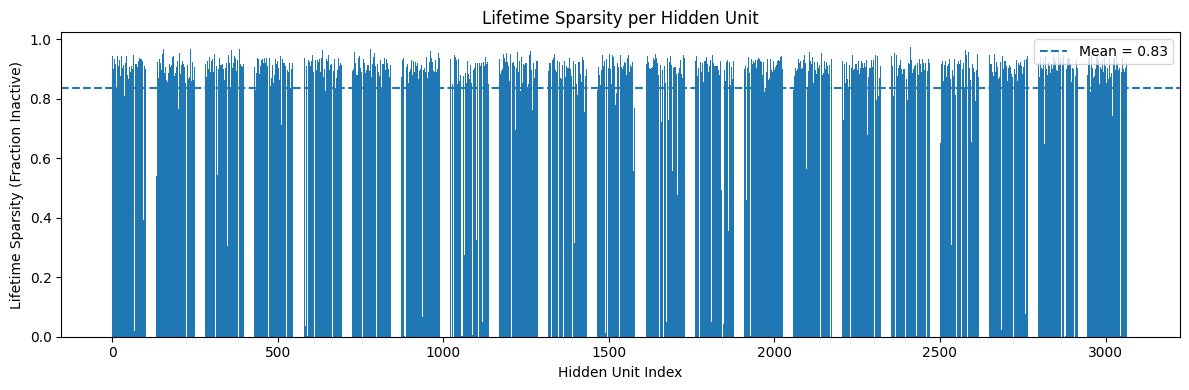

In [ ]:
H = len(sparsity_per_unit)
unit_indices = np.arange(H)

plt.figure(figsize=(12, 4))
plt.bar(unit_indices, sparsity_per_unit)
plt.axhline(sparsity_per_unit.mean(), linestyle='--',
            label=f"Mean = {sparsity_per_unit.mean():.2f}")
plt.xlabel("Hidden Unit Index")
plt.ylabel("Lifetime Sparsity (Fraction Inactive)")
plt.title("Lifetime Sparsity per Hidden Unit")
plt.legend()
plt.tight_layout()
plt.show()

We also want to plot a histogram of hidden unit sparsities -- how are they clustered?

x-axis: % active
y-axis: # of neurons with that % active

<ipython-input-23-1e7d97fabe1e>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


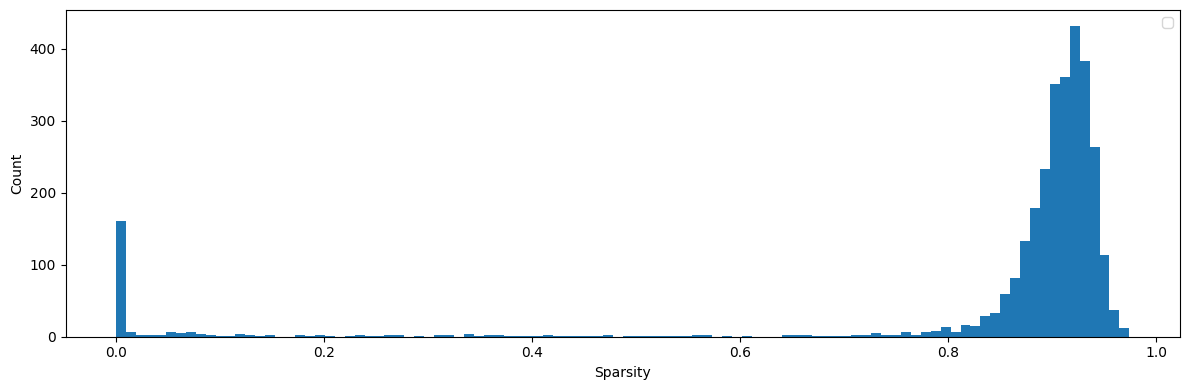

In [ ]:
#for j, sp in enumerate(sparsity_per_unit):
#    print(f"  Unit {j:2d}: {100*sp:.1f}% inactive")

# Sparsity_per_unit is [95, 63, 54, etc.]
plt.figure(figsize=(12, 4))
x_sorted = sorted(sparsity_per_unit)
n_bins = H//30

plt.hist(x_sorted, bins = n_bins)
plt.xlabel("Sparsity")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

## (Deprecated) Model Tests (don't need to run)

Here's the plan:
- Import the CLIP model, inspect it, choose a layer near the end.
- Write my own code for a very simple SAE (using linear layers) and my own training loop

In [ ]:
print(model_resnet)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [ ]:
print(model_vit)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Test the model by handing it some images, making sure it runs.

In [ ]:
dataset = torchvision.datasets.CIFAR10(
    root="data", train=True, download=True # NOTE THAT THIS IS THE TRAIN DATASET
)

In [ ]:
batch_imgs_vit = torch.stack([
    vit_preprocess(img)
    for img, _ in [dataset[i] for i in range(64)] # takes in a mini batch of 64 images
]).to(vit_device)

outs_vit = model_vit.encode_image(batch_imgs_vit)

In [ ]:
batch_imgs_resnet = torch.stack([
    resnet_preprocess(img) # img is already a PIL Image
    for img, _ in [dataset[i] for i in range(64)]
]).to(resnet_device)

outs_resnet = model_resnet.encode_image(batch_imgs_resnet)

Hook for hidden states (necessary for open ai clip models, not needed for huggingface)

In [ ]:
def top_k_images(sae_model, dataset, device, k=5, batch_size=32, n=10):

  hidden_states = []
  def hook_fn(module, input, output):
    hidden_states.append(output)

  for h in list(getattr(model_vit, '_sae_hooks', [])):
    h.remove()

  model_vit._sae_hooks = []
  for blk in model_vit.visual.transformer.resblocks:
    h = blk.register_forward_hook(hook_fn)
    model_vit._sae_hooks.append(h)

  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  print("Using batch_size=", batch_size, "=> will process",
      len(loader) * batch_size, "images total")
  sae_model.eval()
  sae_model.to(device)

  activations = []
  images = []
  latents = []

  vit_dtype  = model_vit.visual.conv1.weight.dtype
  with torch.no_grad():
    for x, _ in loader:
      x = x.to(device)
      for img in x.cpu():
        #save raw images for displaying top k later
        images.append(img)
      x_vit = x.to(vit_dtype)
      hidden_states.clear()
      _ = model_vit.visual(x_vit)

      h = hidden_states[-1]
      h = h.permute(1, 0, 2)
      feats = h.mean(dim=1)
      feats = feats.float()
      feats = feats.to(device)
      _, z = sae_model(feats)

      latents.append(z.cpu())
      scores = torch.sum(torch.abs(z), dim=1)
      activations.append(scores.cpu())


  activations = torch.cat(activations)
  images = torch.stack(images, dim=0)
  z_matrix = torch.cat(latents, dim=0)

  topk_vals, topk_idx = torch.topk(activations, k)
  selected_z = z_matrix[topk_idx]
  unit_means = selected_z.abs().mean(dim=0)
  top_unit_vals, top_unit_idx = torch.topk(unit_means, n)
  return images[topk_idx], topk_vals, top_unit_vals, top_unit_idx

def show_image_grid(imgs, titles=None, nrow=5):
  k = imgs.shape[0]
  ncol = int(np.ceil(k / nrow))
  fig, axes = plt.subplots(ncol, nrow, figsize=(nrow*2, ncol*2))
  axes = axes.flatten()

  for i in range(k):
    img = imgs[i]
    if img.dim() == 2:
            img = img.unsqueeze(0).repeat(3,1,1)
    img = img.permute(1,2,0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')
    if titles is not None:
      axes[i].set_title(f"{titles[i]:.2f}", fontsize=8)
    for j in range(k, len(axes)):
      axes[j].axis('off')
  plt.show()

def show_active_units(top_unit_vals, top_unit_idx):
  plt.bar(top_unit_idx.cpu().numpy().astype(str),
          top_unit_vals.cpu().numpy())
  plt.xlabel('Latent Unit Index')
  plt.ylabel('Mean |Activation|')
  plt.title('Top 10 Most Active SAE Units')
  plt.show()

In [ ]:
subset_size = len(train_dataset) // 10
indices = list(range(subset_size))
subset = Subset(train_dataset, indices)
top_imgs, top_scores, top_unit_vals, top_unit_idx = top_k_images(sae_vit, subset, vit_device, k=20, batch_size=20)
show_image_grid(top_imgs, titles=top_scores.tolist(), nrow=3)
show_active_units(top_unit_vals, top_unit_idx)

## (Deprecated) Overfitting the SAE on a batch

Training loop:
1. Run an image batch through the CLIP model, therefore saving activations in activations["vit_hook"] (should be [N x dim])
2. forward pass on the SAE, evaluating loss
3. step the optimizer

In [ ]:
loss_criterion = torch.nn.MSELoss()
l1 = 1e-3
optimizer = torch.optim.Adam(sae_vit.parameters(), lr=2e-4)

loss_history = []
vit_batches = [batch_imgs_vit for i in range(30)]

# recall: dataset was defined above.

for batch in vit_batches:
  # Zero the grad
  optimizer.zero_grad()

  dummy_out = model_vit.encode_image(batch)
  sae_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)

  sae_preds, latents = sae_vit(sae_y)

  loss = loss_criterion(sae_preds, sae_y) + l1 * latents.abs().mean()
  loss_history.append(loss)

  loss.backward()
  optimizer.step()

loss_history = [item.item() for item in loss_history]
print(loss_history)

Plot the loss history:

In [ ]:
plt.plot(range(len(loss_history)), loss_history)
plt.show()